# Importing and Setting Up GDrive

In [ ]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import time

from sklearn.model_selection import train_test_split
from scipy import sparse

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Change directory here!
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


# Reading Data

In [ ]:
train_all = pd.read_csv('assignment_2_ratings_train.csv')
train_all.shape

(4436068, 3)

In [ ]:
#Shuffle the Dataset
train_all_shuffled = train_all.sample(frac = 1)
train_all_shuffled.head()

,user_id,anime_id,rating
3417569,71226,16870,10
623137,4019,7858,8
3079356,22815,9041,6
3616613,62510,8407,8
4103570,73305,6351,8


In [ ]:
#Perform 80-20 Train Validation Split
train, valid = train_test_split(train_all_shuffled, test_size=0.2)

# Computing Averages by User and Anime

In [ ]:
#Obtaining the Average Rating by Anime
train_avg_by_anime = train.groupby('anime_id')[['rating']].mean()
train_avg_by_anime.head()

,rating
anime_id,
1,8.868205
5,8.446691
6,8.405216
7,7.486418
8,7.177143


In [ ]:
#Obtaining the Average Rating by User
train_avg_by_user = train.groupby('user_id')[['rating']].mean()
train_avg_by_user.head()

,rating
user_id,
1,10.000000
3,7.560000
5,4.464844
7,7.333333
8,7.000000


# Weighted Average of User Mean and Anime Mean

The weights are obtained from the other notebook "RecommendingWithAverages.ipynb"

In [ ]:
#Converting Training Dataset to numpy array
train_np = jnp.array(train)
#Converting Validation Dataset to numpy array
val_np = jnp.array(valid)

In [ ]:
#Retrieving the columns from the training dataset
train_user_ids, train_anime_ids, train_ratings = train_np[:,0], train_np[:,1], train_np[:,2]

In [ ]:
#Getting the training residuals from the Weighted Average Model
train_pred = 0.59*jnp.array(train_avg_by_user.loc[train_user_ids,].rating) + (1-0.59)* jnp.array(train_avg_by_anime.loc[train_anime_ids,].rating)
train_res = train_ratings - train_pred

In [ ]:
# Generate Set of unique User IDs and Anime IDs
user_set = set(train_avg_by_user.index)
anime_set = set(train_avg_by_anime.index)

In [ ]:
# Splits a validation set into 4 categories, in_both denotes entries where both user and anime exists in the training dataset, in_user denotes that only user exists, 
# in_anime denotes that only anime exists, and in_none denotes that anime and user both do not exist in the trainig dataset
# Returns the 4 lists which contain indices denoting which row belongs to which category
def split_category(x, user_set, anime_set):
  user_id, anime_id, rating = np.array(x[:,0]), np.array(x[:,1]), np.array(x[:,2])
  in_both = np.array([i for i in range(len(x)) if user_id[i] in user_set and anime_id[i] in anime_set])
  in_user = np.array([i for i in range(len(x)) if user_id[i] in user_set and anime_id[i] not in anime_set])
  in_anime = np.array([i for i in range(len(x)) if user_id[i] not in user_set and anime_id[i] in anime_set])
  in_none = np.array([i for i in range(len(x)) if user_id[i] not in user_set and anime_id[i] not in anime_set])
  return in_both, in_user, in_anime, in_none
  

In [ ]:
#Splitting Validation Set into 4 categories
in_both, in_user, in_anime, in_none = split_category(val_np, user_set, anime_set)

In [ ]:
#Getting columns from validation set
valid_user_id, valid_anime_id, valid_rating = np.array(val_np[:,0]), np.array(val_np[:,1]), np.array(val_np[:,2])

In [ ]:
#Create validation batch (to be used in the training loop) using 1st category (in_both)
#simpler computation as both user and anime id exist in the training set for this category
val_batch_user_id = valid_user_id[in_both]
val_batch_anime_id = valid_anime_id[in_both]
val_batch_ratings = valid_rating[in_both]

In [ ]:
#Generating residuals for validation batch
val_batch_pred = 0.59*jnp.array(train_avg_by_user.loc[val_batch_user_id,].rating) + (1-0.59)* jnp.array(train_avg_by_anime.loc[val_batch_anime_id,].rating)
val_batch_res = val_batch_ratings - val_batch_pred

# Training Factor Model on Residuals

In [ ]:
#Loss Function
def loss(U,V,u_list,f_list,actual_res):
  pred_res = jnp.sum(U[u_list]*V[f_list], axis = 1)
  return jnp.mean((pred_res-actual_res)**2)

In [ ]:
#Gradient Functions
U_grad = jax.jit(jax.grad(loss, argnums = 0))
V_grad = jax.jit(jax.grad(loss, argnums = 1))

In [ ]:
#Generating the list of unique User and Anime IDs
train_user_id_all = list(set(train_avg_by_user.index))
train_anime_id_all = list(set(train_avg_by_anime.index))

In [ ]:
#Generating Dimension of Matrices, +1 to avoid index errors
p = max(train_user_id_all) + 1
q = max(train_anime_id_all) + 1
r = 10
print(p,q)

73517 34368


In [ ]:
# Initialise U and V, check below for proper intialization
U_init = np.random.normal(0,0.6,size = (p,r))
V_init = np.random.normal(0,0.6,size = (q,r))

# Tuning Initialisation Params

In [ ]:
#Ratings computed by U_init and V_init
initial_res = jnp.sum(U_init[train_user_ids]*V_init[train_anime_ids], axis = 1)

(array([  4.,  11.,  27.,  61., 149., 439., 915., 848., 486.,  60.]),
 array([-6.80600262, -5.81203461, -4.81806707, -3.8240993 , -2.83013153,
        -1.83616376, -0.84219599,  0.15177178,  1.14573956,  2.13970733,
         3.1336751 ]),
 <BarContainer object of 10 artists>)

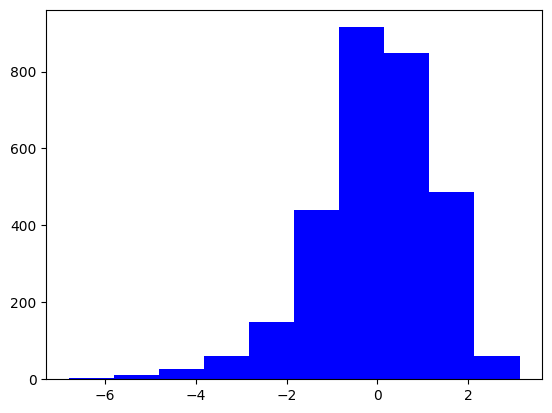

In [ ]:
#Plotting histogram of ratings from a sample of the training dataset
sample = np.random.randint(0, len(train_res),3000)
plt.hist(train_res[sample], color = "blue")

(array([ 11.,  24., 141., 522., 947., 854., 374., 106.,  17.,   4.]),
 array([-4.46473646, -3.55304146, -2.64134645, -1.72965145, -0.81795645,
         0.09373856,  1.00543356,  1.91712856,  2.82882357,  3.74051857,
         4.65221357]),
 <BarContainer object of 10 artists>)

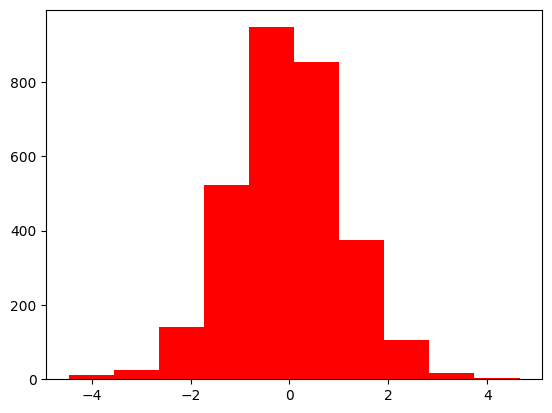

In [ ]:
#Plotting histogram of predicted ratings from the same sample from dot product of U_init and V_init
plt.hist(initial_res[sample], color = "red")

# Training Loop

In [ ]:
#Copy U and V
U = jnp.array(np.copy(U_init))
V = jnp.array(np.copy(U_init))

In [ ]:
#training loop
epochs = 75
batch_size = 8192
lr = 1
trloss_traj = []
val_loss_traj = []
#For momentum calculation
change_u = None
change_v = None
for i in range(epochs):
  batches = jnp.arange((train_np.shape[0]//batch_size)+1)
  for batch in tqdm(batches):
    if batch != batches[-1]:
      start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
    else:
      start, end = int(batch*batch_size), None
    u_list = train_user_ids[start:end]
    f_list = train_anime_ids[start:end]
    actual_res = jnp.array(train_res[start:end])
    #Compute Gradients
    u_g  = U_grad(U,V,u_list,f_list,actual_res)
    v_g = V_grad(U,V,u_list,f_list,actual_res)
    if change_u == None and change_v == None:
      #No momentum updates on first iteration
      U = U - lr*u_g
      V = V - lr*v_g 
      change_u = lr*u_g
      change_v = lr*v_g
    else:
      #SGD with 0.9*momentum
      U = U - lr*u_g - 0.9*change_u
      V = V - lr*v_g - 0.9*change_v
      change_u = lr*u_g + 0.9*change_u
      change_v = lr*v_g + 0.9*change_v
  
  print(f"epoch:{i}")
  #Compute Training Loss on a single training batch of size 512
  u_list = train_user_ids[0:512]
  f_list = train_anime_ids[0:512]
  actual_res = jnp.array(train_res[0:512])
  tr_loss = loss(U,V, u_list,f_list,actual_res)
  print(f"training loss: {tr_loss}")
  trloss_traj.append(tr_loss)

  #Compute Validation Loss on a single validation batch of size 512
  u_list = val_batch_user_id[0:512]
  f_list = val_batch_anime_id[0:512]
  actual_res = jnp.array(val_batch_res[0:512])
  val_loss = loss(U,V, u_list,f_list,actual_res)
  print(f"val loss: {val_loss}")
  val_loss_traj.append(val_loss)

  0%|          | 0/434 [00:00<?, ?it/s]

epoch:0
training loss: 2.002615213394165
val loss: 1.9927717447280884


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:1
training loss: 1.877715826034546
val loss: 1.9273616075515747


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:2
training loss: 1.8300917148590088
val loss: 1.9053133726119995


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:3
training loss: 1.8034358024597168
val loss: 1.893314242362976


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:4
training loss: 1.785421371459961
val loss: 1.8849718570709229


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:5
training loss: 1.7718675136566162
val loss: 1.8781852722167969


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:6
training loss: 1.7609210014343262
val loss: 1.8719804286956787


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:7
training loss: 1.7515742778778076
val loss: 1.8657528162002563


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:8
training loss: 1.743169903755188
val loss: 1.8590173721313477


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:9
training loss: 1.7351957559585571
val loss: 1.8513083457946777


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:10
training loss: 1.727190613746643
val loss: 1.8421506881713867


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:11
training loss: 1.718716025352478
val loss: 1.8310892581939697


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:12
training loss: 1.7093874216079712
val loss: 1.8177927732467651


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:13
training loss: 1.6989673376083374
val loss: 1.8022141456604004


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:14
training loss: 1.6874680519104004
val loss: 1.784728765487671


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:15
training loss: 1.6751686334609985
val loss: 1.7661283016204834


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:16
training loss: 1.6624857187271118
val loss: 1.7474117279052734


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:17
training loss: 1.649785041809082
val loss: 1.7294868230819702


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:18
training loss: 1.6372852325439453
val loss: 1.7129631042480469


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:19
training loss: 1.6250855922698975
val loss: 1.6981115341186523


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:20
training loss: 1.6132382154464722
val loss: 1.6849396228790283


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:21
training loss: 1.6017937660217285
val loss: 1.6732995510101318


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:22
training loss: 1.5908105373382568
val loss: 1.6629763841629028


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:23
training loss: 1.580345630645752
val loss: 1.6537456512451172


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:24
training loss: 1.5704424381256104
val loss: 1.6454046964645386


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:25
training loss: 1.5611252784729004
val loss: 1.6377825736999512


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:26
training loss: 1.55239737033844
val loss: 1.6307423114776611


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:27
training loss: 1.5442430973052979
val loss: 1.6241776943206787


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:28
training loss: 1.536631464958191
val loss: 1.6180057525634766


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:29
training loss: 1.5295205116271973
val loss: 1.6121633052825928


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:30
training loss: 1.5228620767593384
val loss: 1.6066009998321533


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:31
training loss: 1.5166044235229492
val loss: 1.6012792587280273


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:32
training loss: 1.5106966495513916
val loss: 1.5961668491363525


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:33
training loss: 1.505090594291687
val loss: 1.5912367105484009


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:34
training loss: 1.499741554260254
val loss: 1.5864659547805786


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:35
training loss: 1.4946105480194092
val loss: 1.5818341970443726


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:36
training loss: 1.4896646738052368
val loss: 1.577323079109192


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:37
training loss: 1.4848761558532715
val loss: 1.5729153156280518


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:38
training loss: 1.480222463607788
val loss: 1.5685954093933105


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:39
training loss: 1.4756855964660645
val loss: 1.5643494129180908


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:40
training loss: 1.4712508916854858
val loss: 1.5601651668548584


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:41
training loss: 1.4669067859649658
val loss: 1.5560327768325806


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:42
training loss: 1.4626438617706299
val loss: 1.5519438982009888


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:43
training loss: 1.4584534168243408
val loss: 1.5478928089141846


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:44
training loss: 1.4543282985687256
val loss: 1.5438752174377441


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:45
training loss: 1.4502618312835693
val loss: 1.539888858795166


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:46
training loss: 1.4462478160858154
val loss: 1.5359324216842651


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:47
training loss: 1.4422800540924072
val loss: 1.5320059061050415


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:48
training loss: 1.4383528232574463
val loss: 1.5281102657318115


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:49
training loss: 1.4344606399536133
val loss: 1.5242466926574707


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:50
training loss: 1.4305980205535889
val loss: 1.520416498184204


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:51
training loss: 1.4267600774765015
val loss: 1.5166211128234863


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:52
training loss: 1.4229419231414795
val loss: 1.5128618478775024


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:53
training loss: 1.4191393852233887
val loss: 1.5091397762298584


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:54
training loss: 1.4153481721878052
val loss: 1.5054558515548706


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:55
training loss: 1.4115653038024902
val loss: 1.5018104314804077


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:56
training loss: 1.4077870845794678
val loss: 1.498203992843628


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:57
training loss: 1.4040112495422363
val loss: 1.4946361780166626


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:58
training loss: 1.4002352952957153
val loss: 1.4911072254180908


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:59
training loss: 1.396457552909851
val loss: 1.4876164197921753


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:60
training loss: 1.3926763534545898
val loss: 1.4841630458831787


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:61
training loss: 1.3888908624649048
val loss: 1.4807469844818115


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:62
training loss: 1.3851003646850586
val loss: 1.4773674011230469


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:63
training loss: 1.381304144859314
val loss: 1.4740235805511475


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:64
training loss: 1.377502679824829
val loss: 1.4707155227661133


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:65
training loss: 1.3736956119537354
val loss: 1.4674421548843384


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:66
training loss: 1.3698837757110596
val loss: 1.4642034769058228


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:67
training loss: 1.366067886352539
val loss: 1.4609992504119873


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:68
training loss: 1.3622485399246216
val loss: 1.4578289985656738


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:69
training loss: 1.358426809310913
val loss: 1.4546931982040405


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:70
training loss: 1.354603886604309
val loss: 1.4515914916992188


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:71
training loss: 1.3507808446884155
val loss: 1.4485244750976562


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:72
training loss: 1.3469593524932861
val loss: 1.4454922676086426


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:73
training loss: 1.343140721321106
val loss: 1.442495346069336


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:74
training loss: 1.3393266201019287
val loss: 1.4395344257354736


# Evaluation on Validation Set

In [ ]:
#Getting Mean Factors (ignore rows that do not belong to any anime, user in the training set)
rel_U = U[train_user_id_all,]
rel_V = V[train_anime_id_all,]
mean_user_factor = jnp.mean(rel_U, axis = 0)
mean_anime_factor = jnp.mean(rel_V, axis = 0)

In [ ]:
global_avg_rating = jnp.mean(train_np[:,2])

In [ ]:
#in_none is left out as it is empty
#Predictions below 1 and above 10 are set to 1 and 10 respectively using the clip method
#For in_user and in_anime, the mean factors are used as a substitute to compute the predictions
def factor_valid_mse(x, in_both, in_user, in_anime):
  c = 0.59
  user_id, anime_id, rating = np.array(x[:,0]), np.array(x[:,1]), np.array(x[:,2])
  squared_error = 0
  if len(in_both)>0:
    res_both = jnp.sum(U[user_id[in_both]]*V[anime_id[in_both]], axis = 1)
    pred_both = jnp.array(train_avg_by_user.loc[user_id[in_both],].rating)*c + jnp.array(train_avg_by_anime.loc[anime_id[in_both],].rating)*(1-c) + res_both
    pred_both = jnp.clip(pred_both,1,10)
    squared_error += jnp.sum((pred_both-np.array(rating[in_both]))**2)
  #Pred for in User only
  if len(in_user)>0:
    res_user = jnp.sum(U[user_id[in_user]]*mean_anime_factor, axis = 1)
    pred_user = jnp.array(train_avg_by_user.loc[user_id[in_user],].rating)*c + global_avg_rating*(1-c) + res_user
    pred_user = jnp.clip(pred_user,1,10)
    squared_error += jnp.sum((pred_user-np.array(rating[in_user]))**2)
  #Pred for in Anime only
  if len(in_anime)>0:
    res_anime = jnp.sum(V[anime_id[in_anime]]*mean_user_factor, axis = 1)
    pred_anime = global_avg_rating*c + jnp.array(train_avg_by_anime.loc[anime_id[in_anime],].rating)*(1-c) + res_anime
    pred_anime = jnp.clip(pred_anime,1,10)
    squared_error += jnp.sum((pred_anime-np.array(rating[in_anime]))**2)
  return squared_error/len(x)

In [ ]:
factor_valid_mse(val_np, in_both, in_user , in_anime )

Array(1.4602847, dtype=float32)

With a Factor Model, we could bring the MSE down from 1.70 to 1.46